Render OpenAI Gym Environments from CoLab

It is possible to visualize the game your agent is playing, even on CoLab. This section provides information on generating a video in CoLab that shows you an episode of the game your agent is playing. I based this video process on suggestions found here.

Begin by installing pyvirtualdisplay and python-opengl.


In [ ]:
# HIDE OUTPUT
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
# HIDE OUTPUT
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

     |████████████████████████████████| 1.2 MB 4.7 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(800, 600))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""


def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")


def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

In [ ]:
# HIDE OUTPUT
env = wrap_env(gym.make("CartPole-v1"))

observation = env.reset()

while True:

    env.render()

    # your agent goes here
    action = env.action_space.sample()

    observation, reward, done, info = env.step(action)

    if done:
        break

env.close()
show_video()

In [ ]:
print(env.action_space)
print(env.observation_space)

Discrete(2)
Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


In [ ]:
import torch
import random
from torch import nn

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [ ]:
class DQN(nn.Module):
    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
          nn.Linear(state_space_dim,64),
          nn.Tanh(),
          nn.Linear(64,64*2),
          nn.Tanh(),
          nn.Linear(64*2,action_space_dim)
        )

    def forward(self, x):        
        return self.linear(x)

In [ ]:
class DQNAgent():
  def __init__(self, state_space_dim, action_space_dim):
    self.state_space_dim = state_space_dim
    self.action_space_dim = action_space_dim
    self.gamma = 0.9
      
    self.net = DQN(state_space_dim, action_space_dim)
    self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.001) 
    
  def choose_action(self, state, epsilon):                            
    if random.random() < epsilon:
      return random.choice(range(self.action_space_dim))
            
    with torch.no_grad():      
      state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
      net_out = self.net(state)

    action = int(net_out.argmax())
            
    return action

  def update_dqn(self, target, predict):    
    loss = (target - predict) ** 2    
    self.optimizer.zero_grad()
    loss.backward()    
    nn.utils.clip_grad_norm_(self.net.parameters(), 2)
    self.optimizer.step()

  def update(self, state, action, reward, state2):
    state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
    state2 = torch.tensor(state2, dtype=torch.float32) # Convert the state to tensor
    
    predict = self.net(state)[action]

    with torch.no_grad():      
      q_value = self.net(state2).max()

    target = reward + self.gamma * q_value
    self.update_dqn(target, predict)            
                
  def update_final(self, state, action, reward):
    state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
    
    predict = self.net(state)[action]
    target = reward
    
    self.update_dqn(target, predict)

In [ ]:
max_steps = 200

def train_agent(env, agent, total_episodes = 100, epsilon=0.1):
    rewards = []    
     
    for episode in tqdm(range(total_episodes)):
        t = 0
        state1 = env.reset()        
        action1 = agent.choose_action(state1, epsilon=epsilon)

        episode_reward = 0

        while True:                     
            state2, reward, done, info = env.step(action1)
        
            episode_reward += reward
            
            t += 1
        
            if not done:                                        
                agent.update(state1, action1, reward, state2)                        
            else:
                reward -= 1  
                agent.update_final(state1, action1, reward)
                     
            if t >= max_steps or done:
                rewards.append(episode_reward)
                break

            state1 = state2            
            action1 = agent.choose_action(state1, epsilon=epsilon)

    return rewards

  0%|          | 0/100 [00:00<?, ?it/s]

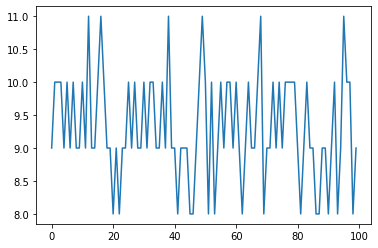

In [ ]:
agent = DQNAgent(4, 2)

rewards = train_agent(env, agent, 100)

plt.plot(rewards)

  0%|          | 0/1000 [00:00<?, ?it/s]

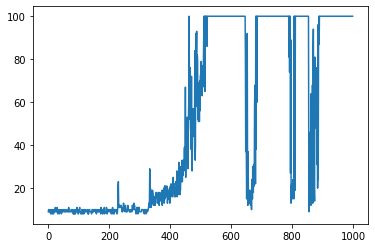

In [ ]:
rewards = train_agent(env, agent, 1000)

plt.plot(rewards)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
from collections import deque

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, transition):
        """Save a transition"""
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
class MemoryAgent():
  def __init__(self, state_space_dim, action_space_dim):
    self.state_space_dim = state_space_dim
    self.action_space_dim = action_space_dim
    self.gamma = 0.9
    self.memory = ReplayMemory(10000)
      
    self.net = DQN(state_space_dim, action_space_dim).to(device)
    self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.001) 
    
  def choose_action(self, state, epsilon):                            
    if random.random() < epsilon:
      action = random.choice(range(self.action_space_dim))
            
    with torch.no_grad():      
      state = torch.tensor(state, dtype=torch.float32, device=device) # Convert the state to tensor
      net_out = self.net(state)

    action = int(net_out.argmax())
            
    return action

  def train_dqn(self):
    if len(self.memory) < 32:
      return

    batch = self.memory.sample(32)
    
    state1, action, reward, state2, is_final = zip(*batch)

    state1 = torch.tensor(state1, dtype=torch.float32, device=device)
    action = torch.tensor(action, device=device)
    reward = torch.tensor(reward, dtype=torch.float32, device=device)
    state2 = torch.tensor(state2, dtype=torch.float32, device=device)
    is_final = torch.tensor(is_final, dtype=torch.float32, device=device)    

    predict = self.net(state1).gather(1, action.unsqueeze(1))    

    with torch.no_grad():      
      q_value, _ = self.net(state2).max(dim=1)

    target = reward + self.gamma * q_value * (1 - is_final)
    
    #print(predict.shape, target.shape)
    criterion = nn.MSELoss()
    loss = criterion(predict, target.unsqueeze(1)) 
    
    self.optimizer.zero_grad()
    loss.backward()    
    nn.utils.clip_grad_norm_(self.net.parameters(), 1)
    self.optimizer.step()

    return loss.detach().cpu().numpy()
  
  def update(self, state, action, reward, state2):
    self.memory.push((state, action, reward, state2, False))

    self.train_dqn()    
                
  def update_final(self, state, action, reward):
    self.memory.push((state, action, reward, state, True))

    self.train_dqn()    

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


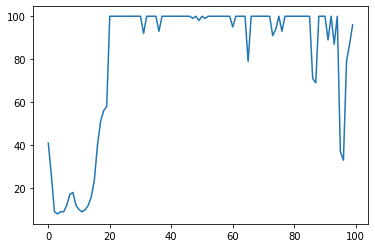

In [ ]:
agent = MemoryAgent(4, 2)

rewards = train_agent(env, agent, 100)

plt.plot(rewards)

  0%|          | 0/100 [00:00<?, ?it/s]

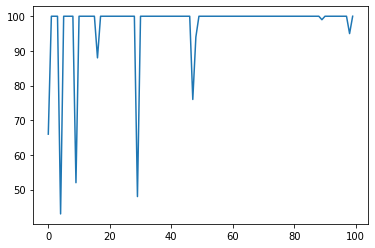

In [ ]:
rewards = train_agent(env, agent, 100)

plt.plot(rewards)

In [ ]:
class DoubleDQNAgent():
  def __init__(self, state_space_dim, action_space_dim):
    self.state_space_dim = state_space_dim
    self.action_space_dim = action_space_dim
    self.gamma = 0.9
    self.memory = ReplayMemory(10000)
      
    self.net1 = DQN(state_space_dim, action_space_dim).to(device)
    self.net2 = DQN(state_space_dim, action_space_dim).to(device)
    self.optimizer1 = torch.optim.Adam(self.net1.parameters(), lr=0.001) 
    self.optimizer2 = torch.optim.Adam(self.net2.parameters(), lr=0.001) 
    
  def choose_action(self, state, epsilon):                            
    if random.random() < epsilon:
      action = random.choice(range(self.action_space_dim))
            
    net = random.choice([self.net1, self.net2])
    with torch.no_grad():      
      state = torch.tensor(state, dtype=torch.float32, device=device) # Convert the state to tensor
      net_out = net(state)

    action = int(net_out.argmax())
            
    return action

  def train_dqn(self):
    if len(self.memory) < 32:
      return

    batch = self.memory.sample(32)

    if np.random.rand() < .5:
      net_a, net_b, optimizer = self.net1, self.net2, self.optimizer1
    else:
      net_a, net_b, optimizer = self.net2, self.net1, self.optimizer2
    
    state1, action, reward, state2, is_final = zip(*batch)

    state1 = torch.tensor(state1, dtype=torch.float32, device=device)
    action = torch.tensor(action, device=device)
    reward = torch.tensor(reward, dtype=torch.float32, device=device)
    state2 = torch.tensor(state2, dtype=torch.float32, device=device)
    is_final = torch.tensor(is_final, dtype=torch.float32, device=device)    



    predict = net_a(state1).gather(1, action.unsqueeze(1))    

    with torch.no_grad():      
      q_value, _ = net_b(state2).max(dim=1)

    target = reward + self.gamma * q_value * (1 - is_final)
    
    criterion = nn.MSELoss()
    loss = criterion(predict, target.unsqueeze(1)) 
    
    optimizer.zero_grad()
    loss.backward()    
    nn.utils.clip_grad_norm_(net_a.parameters(), 1)
    optimizer.step()

    return loss.detach().cpu().numpy()
  
  def update(self, state, action, reward, state2):
    self.memory.push((state, action, reward, state2, False))

    self.train_dqn()    
                
  def update_final(self, state, action, reward):
    self.memory.push((state, action, reward, state, True))

    self.train_dqn()    

  0%|          | 0/100 [00:00<?, ?it/s]

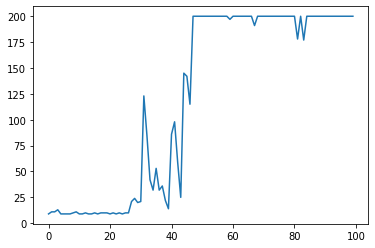

In [ ]:
agent = DoubleDQNAgent(4, 2)

rewards = train_agent(env, agent, 100)

plt.plot(rewards)

  0%|          | 0/100 [00:00<?, ?it/s]

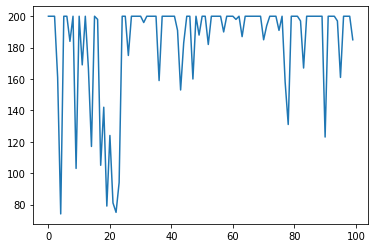

In [ ]:
rewards = train_agent(env, agent, 100, epsilon=0.01)

plt.plot(rewards)

In [ ]:
# HIDE OUTPUT
env = wrap_env(gym.make("CartPole-v1"))

state = env.reset()

while True:

    env.render()

    # your agent goes here
    action = agent.choose_action(state, epsilon=0.0)   

    state, reward, done, info = env.step(action)

    if done:
        break

env.close()
show_video()